<a href="https://colab.research.google.com/github/Nannanpeng/Econ_Dynamic_Programming/blob/master/Income_fluctuation_problem_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade quantecon
!pip install interpolation

Requirement already up-to-date: quantecon in /usr/local/lib/python3.6/dist-packages (0.4.8)


In [2]:
import numpy as np
from quantecon.optimize import brent_max, brentq
from interpolation import interp
from numba import njit, float64, jitclass, prange
import matplotlib.pyplot as plt
%matplotlib inline
from quantecon import MarkovChain

In [3]:
ifp_data=[('a_r', float64),
     ('b_r', float64),
     ('a_y', float64),
     ('b_y', float64),
     ('beta', float64),
     ('gamma', float64),
     ('P', float64[:,:]),
     ('s_grids', float64[:]),
     ('eta_draws', float64[:]),
     ('zeta_draws', float64[:])
    ]

@jitclass(ifp_data)
class IFPModel2:
  def __init__(self, beta=0.96,
            gamma=1.5,
            P=((0.9, 0.1),
             (0.1, 0.9)),
            a_r=0.1, 
            b_r=0.0,
            a_y=0.2,
            b_y=0.5,
            mc_size=50,
            grid_min=0,
            grid_max=10,
            grid_size=100,
            seed=1234):
    
    self.beta, self.gamma = beta, gamma
    self.a_r, self.b_r, self.a_y, self.b_y = a_r, b_r, a_y, b_y
    self.s_grids = np.linspace(grid_min, grid_max, grid_size)
    self.P = np.array(P)
    np.random.seed(seed)
    self.eta_draws = np.random.randn(mc_size)
    self.zeta_draws = np.random.randn(mc_size)

    self._check_stability()

  def R(self, z, shock):
    a_r, b_r = self.a_r, self.b_r
    return np.exp(a_r*shock + b_r)
  
  def Y(self, z, shock):
    a_y, b_y = self.a_y, self.b_y
    return np.exp(a_y*shock+z*b_y)

  def _check_stability(self):
    a_r, b_r, beta = self.a_r, self.b_r, self.beta
    expected_R = np.exp(b_r + a_r**2/2)
    assert beta*expected_R < 1, 'Stability condition is violated!'

  def u(self, c):
    gamma = self.gamma
    return np.log(c) if gamma == 1 else c**(1-gamma)/(1-gamma) 
  
  def u_prime(self, c):
    gamma = self.gamma
    return 1/c if gamma==1 else c**(-gamma) 
  
  def u_prime_inverse(self, u):
    gamma = self.gamma
    return 1/u if gamma==1 else u**(-1/gamma)

@njit
def compute_consumption(s, z, a_grids, sigma, ifp):
  R, Y = ifp.R, ifp.Y
  u_prime_inverse, beta, P = ifp.u_prime_inverse, ifp.beta, ifp.P
  eta_draws, zeta_draws = ifp.eta_draws, ifp.zeta_draws
  u_prime = ifp.u_prime

  def Sigma(a, z):
    return interp(a_grids[:, z], sigma[:, z], a)

  expected = 0
  for z_hat in range(len(P)):
    for zeta in zeta_draws:
      R_hat = R(z_hat, zeta)
      for eta in eta_draws:
        Y_hat = Y(z_hat, eta)
        expected += R_hat*u_prime(Sigma(R_hat*s + Y_hat, z_hat))*P[z, z_hat]
  expected /= len(zeta_draws)*len(eta_draws)

  return u_prime_inverse(beta*expected)


@njit
def K(sigma, ifp):
  s_grids, P = ifp.s_grids, ifp.P
  Ksigma = np.empty_like(sigma)
  a_grids = np.copy(s_grids).reshape(-1, 1) + sigma
  for z in range(len(P)):
    for i, s in enumerate(s_grids):
      if s < 1e-12:
        Ksigma[i, z] = 0
      else:
        Ksigma[i, z] = compute_consumption(s, z, a_grids, sigma, ifp)
  return Ksigma


def compute_policy_function(ifp, max_iter=1000, tol=1e-4, verbose=True):
  sigma = np.column_stack((ifp.s_grids, ifp.s_grids))

  i = 0
  err = 1 + tol
  while i < max_iter and err > tol:
    Ksigma = K(sigma, ifp)
    i += 1
    err = np.max(np.abs(Ksigma - sigma))
    sigma = Ksigma
    if verbose and i%25==0:
      print(f'Error is {err} at interation {i}.')
    
  if i == max_iter:
    raise RuntimeError('Iteration failed.')
  
  if verbose:
    print(f'\nConverged on interation {i}!')

  return sigma

In [4]:
%%time

ifp = IFPModel2(gamma=1.5, grid_min=0)
sigma = compute_policy_function(ifp)

Error is 0.0016028049918972442 at interation 25.

Converged on interation 45!
CPU times: user 11.7 s, sys: 24.5 ms, total: 11.7 s
Wall time: 11.7 s


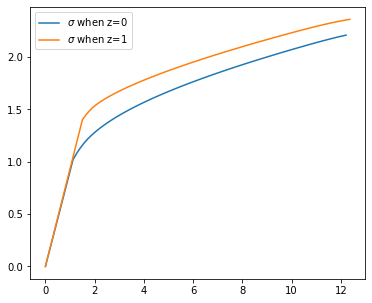

In [5]:
a_grids = ifp.s_grids.reshape(-1, 1) + sigma
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
for i in range(len(ifp.P)):
  ax.plot(a_grids[:, i], sigma[:, i], label=fr'$\sigma$ when z={i}')
ax.legend();

In [6]:
T = 1_000_000
mc = MarkovChain(ifp.P)
z_draws = mc.simulate(ts_length=T, random_state=88)

@njit
def Simulations(ifp, sigma, z_draws, T, a=4):
  s_grids, P, R, Y = ifp.s_grids, ifp.P, ifp.R, ifp.Y
  asset = np.zeros(T+1)
  asset[0] = a
  asset_grids = np.copy(s_grids).reshape(-1, 1) + sigma

  def Sigma(a, z):
    return interp(asset_grids[:, z], sigma[:, z], a)

  for i in range(T):
    c = Sigma(asset[i], z_draws[i])
    eta, zeta = np.random.randn(2)
    R_next = R(z_draws[i], zeta)
    Y_next = Y(z_draws[i], eta)
    asset[i+1] = R_next*(asset[i] - c) + Y_next
  
  return asset

In [7]:
%%time

asset = Simulations(ifp, sigma, z_draws, T)

CPU times: user 1.02 s, sys: 5.02 ms, total: 1.02 s
Wall time: 1.02 s


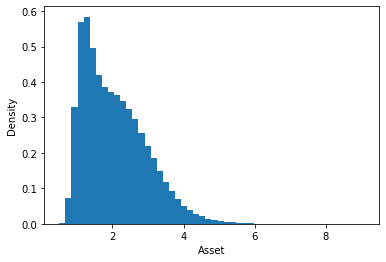

In [8]:
plt.hist(asset, bins=50, density=True)
plt.xlabel('Asset')
plt.ylabel('Density');